## Introduction to the simulation software 

This is a introduction on how to use the provided code to simulate a quantum spin chain. Therefore we will simulate a small system in this example notebook and calculate the entropy as well as the magnetization of a subsystem.

In [1]:
#Import all needed functions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#imports from local helper files
from qm_helper import constructHamilton,constructMagnetization,density_matrix,partial_trace,entropy_vn
from np_helper import state_to_num
from permutations import special_perm,all_perm
from rungekutta import runge_kutta_vec_onerun

The first thing todo is to setup the systems dimension and calculate all possible states of the system. After that we can setup the Hamiltonian of the system.

In [2]:
#system dimensions
N = 2 #num all spins
j = 1 #spins pointing up initially
L = 1 #subsystem size

#Get all possible states in the spin basis of the system
states = special_perm(N,j)
 
# States is now a two dimensional array, containing a 1 for spin up and 0 for spin down.
# However it is more efficient to use integers for the simulation (as described in bsc.pdf)
# Therefore we transform this array to a list of integers
states = state_to_num(states)

#Setup the interaction constants for the Hamiltonian
J = 1
r = 0.5 #this is the anisotropy parameter: delta
# The possibility to include defects or disorder is already provided in the Hamilton function.
# To get the integrable model we must inlcude a zero array (no magnetic field) as a defect list.
epsilons_int = np.zeros(N)

# Now we can calculate the Hamiltonian of the system.
ham_int = constructHamilton(states,J,r,epsilons_int,N)

# ham_int is now a scipy.sparse.csr.csr_matrix that stores the entries more efficient.
# All the other functions are also optimized for this kind of array.

For this small system we are interested in the evolution of the states. How probable is each state for a given time $t$? If write the time evolution as $$\psi(t) = \sum_i \alpha_i(t) \phi_i$$ where $\phi_i$ are the states in the spin basis, the probability of a state $\phi_i$ at a time $t$ is given by $|\alpha_i(t)|^2$. But first we need to define the initial conditions, which are given by the distribution of $\alpha_i(t = 0)$. 

In [3]:
alpha = np.zeros(N,dtype=complex)
alpha[0] = 1 #set the first state as initial state

Now we need to set the constants for the time evolution and some array which stores the values of the coefficients $\alpha_i$ for several times, to plot them later. 

In [4]:
time = 0 #current time
t_step = 0.01 #step at which the system time is increased
times = np.arange(time,20,t_step) # all times for which the system is simulated
save_indices = np.linspace(time,times.shape[0]-1,100,dtype=int) #indices of times array at which we store the system state

#Array for storing coefficients and time
coefficients = np.zeros([save_indices.shape[0],states.shape[0]+1],dtype=complex) 

The Runge-Kutta function can simulate the system with the initial conditions and the Hamiltonian for all the times specified before in the times-array.

In [5]:
counter = 0 # for storing the state of the system
#iterate through all times
for i in range(times.shape[0]):
    # use runge kutta to calculate the next step of the evolution using Schroedinger equation
    time,alpha = runge_kutta_vec_onerun(-1j*ham_int,alpha,t_step,t_start=time)
    #if indice is a indice where we want to save the system state
    if i == save_indices[counter]:
        coefficients[counter,0] = time
        coefficients[counter,1:] = np.copy(alpha)
        counter += 1

The coefficients (or their absolute value) are plotted now against time.

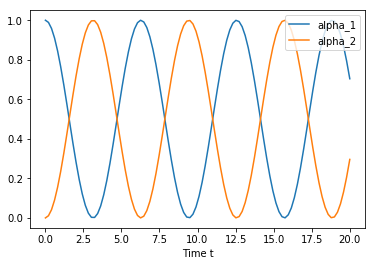

In [6]:
plt.plot(np.real(coefficients[:,0]),np.abs(coefficients[:,1])**2,label='alpha_1')
plt.plot(np.real(coefficients[:,0]),np.abs(coefficients[:,2])**2,label='alpha_2')
plt.xlabel('Time t')
plt.legend(loc='upper right')

We can see that the system starts in the first state, as its coefficient is equal to one. Than the system starts to oscillate and moves completly to the second state. After that it returns to its initial state. This behavior is known as recurrence. We now want to calculate the entropy of a subsystem, which is in this case $L = 1$ big. Therefore we need to calculate the density matrix of the system from the stored coefficients and perform the partical trace to obtain the reduced density matrix. From this reduced density matrix we can calculate the von Neumann entropy of the subsystem.

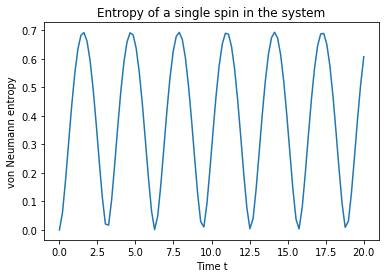

In [7]:
#Array to store entropy for several times
entropy = np.zeros([coefficients.shape[0],2],dtype=float)

#Iterate over all stored coefficients
for i in range(coefficients.shape[0]):
    #set time in entropy array
    entropy[i,0] = np.real(coefficients[i,0])
    #get stored coefficients
    alpha = coefficients[i,1:]
    #calculate density matrix
    density = density_matrix(alpha)
    #calculate reduced density matrix
    red_density = partial_trace(density,np.arange(L,N,1),N,states)
    #calculate von Neumann entropy
    entropy[i,1] = np.real(entropy_vn(red_density))

#Plot the resulting entropy
plt.plot(entropy[:,0],entropy[:,1])
plt.xlabel('Time t')
plt.ylabel('von Neumann entropy')
plt.title('Entropy of a single spin in the system')

As before with the coefficients we see a oscillation with the same frequency as before. Since the system, which is only in one state (i.e. one $\alpha_i = 1$) has zero entropy and the system in a linear combination with same probability for each state maximal entropy, we can not directly say in what state the system is but quantify how large the entanglement in the system is.

Now we can move on to a sligthly bigger system which with $N = 12$ spins. Since there are many more states a plot of every coefficients is too complex, to understand anything about the physics. Hence we only calculate the entropy and the magnetization of a subsystem, which is half the complete system ($L = 6$). 

In [8]:
#Set new system size and coupling constants
N = 12 
j = 6
L = 6
J = 1
r = 0.5
epsilons_int = np.zeros(N)
#Get all possible states of the system
states = state_to_num(special_perm(N,j))
#Calculate the Hamiltonian
ham_int = constructHamilton(states,J,r,epsilons_int,N)
#set the initial state
alpha = np.zeros(states.shape[0])
alpha[450] = 1
#set time constants for time evolution
time = 0 
t_step = 0.01
times = np.arange(time,1000,t_step)

The magnetization is calculated by tracing over the product of the reduced density matrix and the magnetization operator of the subsystem. To calculate the magnetization operator for the system we also need all possible states of the subsystem. 

In [9]:
#Get all states of the subsystem
states_subsystem = state_to_num(all_perm(L))
#Create magnetization operator of subsystem as a numpy array
magnetization_subsystem = constructMagnetization(states_subsystem,np.arange(L)).todense()

We want to store the properties of the system (entropy and magnetization) in a log-scale. Hence we need to store it a logarithmic scaled times. Hence we calculate log scaled storage times and find the corresponding indices to these values from the times array.

In [10]:
#Calculate save indices
save_times = np.logspace(-1,np.log10(np.max(times)),50)
save_indices = np.array([(np.abs(times-t)).argmin() for t in save_times])

#Setup arrays for saving time and variable value
entropy = np.zeros([save_indices.shape[0],2])
magnetization = np.zeros([save_indices.shape[0],2])
counter = 0 #counter for storage

#Time evolution
for i in range(times.shape[0]):
    # use runge kutta to calculate the next step of the evolution using Schroedinger equation
    time,alpha = runge_kutta_vec_onerun(-1j*ham_int,alpha,t_step,t_start=time)
    #check if variables need to be stored
    if i == save_indices[counter]:
        #store times
        entropy[counter,0] = time
        magnetization[counter,0] = time
        #calculate the reduced density matrix
        density = density_matrix(alpha)
        red_density = partial_trace(density,np.arange(L,N,1),N,states)
        #calculate the entropy
        entropy[counter,1] = np.real(entropy_vn(red_density))
        #calculate the magnetization
        magnetization[counter,1] = np.real(np.trace(np.dot(red_density,magnetization_subsystem)))
        counter += 1

You might have noticed that running this time evolution took longer than for the small system. This is due to the dimensionality of the system and also to the partial trace calculation during the simulation. However  we obtained the magnetization and entropy of the subsystem, which we will plot now.

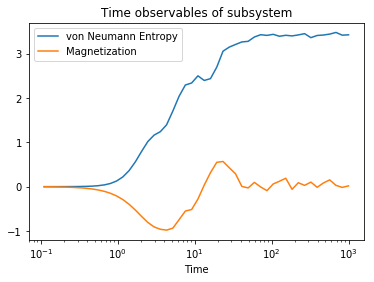

In [11]:
#Set the figure to plot
fig = plt.figure()
ax = plt.gca()
#plot entropy and magnetization
ax.plot(entropy[:,0],entropy[:,1],label='von Neumann Entropy')
ax.plot(magnetization[:,0],magnetization[:,1],label='Magnetization')
#set the x-scale to logarithmic
ax.set_xscale('log')
#set style
plt.legend()
ax.set_xlabel('Time')
ax.set_title('Time observables of subsystem')

In contrast to the first simulation, we can not observe any recurrence in the system but a relaxation to (nearly) constant variables. E.g. the magnetization relaxes to zero and the von Neumann entropy to some maximal value. Hence we unvailed different properties of the spin chains depending on their size. If you want to learn more about spin chains, you can start reading the provided pdf-files and run your own simulations. The next notebook you should study is about level repulsion. 